In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
import livecell_segment.datasets


In [2]:
# model_type='cyto' or 'nuclei' or 'cyto2'
# model = models.Cellpose(gpu=True, model_type="cyto")
pretrained_model_path = "D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\notebooks\\models\\yuzhong_cyto2"
model = models.CellposeModel(pretrained_model=pretrained_model_path, gpu=True)
# list of files
# PUT PATH TO YOUR FILES HERE!
dir_path = Path(
    "D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched"
)
imgs = livecell_segment.datasets.LiveCellImageDataset(dir_path, ext="tif")
img_list = sorted(glob.glob(str(dir_path / "*tif")))


120 tif img file paths loaded: 


In [3]:
img_list[:4]


['D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched\\T001.tif',
 'D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched\\T002.tif',
 'D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched\\T003.tif',
 'D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched\\T004.tif']

In [4]:
def segment_single_image_by_cellpose(image, model, channels=[[0, 0]], diameter=150):
    result_tuple = model.eval([image], diameter=diameter, channels=channels)
    masks = result_tuple[0]
    return masks[0]


def segment_single_images_by_cellpose(images, model, channels=[[0, 0]], diameter=150):
    masks, flows, styles, diams = model.eval(
        images, diameter=diameter, channels=channels
    )
    return masks


Define detectron segmentation

In [8]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


def gen_detectron_predictor_cfg(output_dir):
    cfg = get_cfg()

    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )
    )
    cfg.DATASETS.TRAIN = ("deepfashion_val",)
    cfg.DATASETS.TEST = ()
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )  # Let training initialize from model zoo

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.001
    cfg.SOLVER.WARMUP_ITERS = 1000
    cfg.SOLVER.MAX_ITER = 300
    cfg.SOLVER.STEPS = (1000, 1500)
    cfg.SOLVER.GAMMA = 0.05
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

    cfg.TEST.EVAL_PERIOD = 500
    cfg.OUTPUT_DIR = output_dir
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
        0.55  # set the testing threshold for this model
    )
    cfg.DATASETS.TEST = ("deepfashion_val",)
    predictor = DefaultPredictor(cfg)
    return predictor


DETECTRON_PREDICTOR = gen_detectron_predictor_cfg("./detectron_run0_output/")


def segment_by_detectron(img):
    outputs = DETECTRON_PREDICTOR(img)
    return outputs


[08/29 08:55:42 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [9]:
test_img = imgs[0]
test_mask = segment_single_image_by_cellpose(imgs[0], model)


## Create overlay images

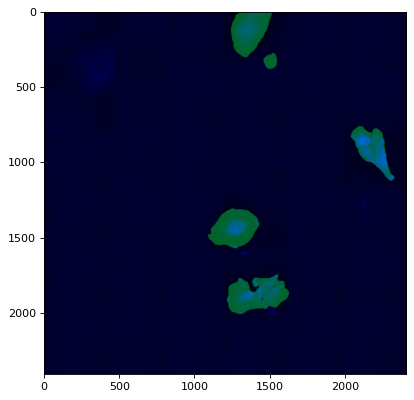

In [10]:
def normalize_img_by_zscore(img: np.array):
    """calculate z score of img and normalize to range [0, 255]

    Parameters
    ----------
    img : np.array
        _description_

    Returns
    -------
    _type_
        _description_
    """
    img = (img - np.mean(img.flatten())) / np.std(img.flatten())
    img = img + abs(np.min(img.flatten()))
    img = img / np.max(img) * 255
    return img


def overlay(image, mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=1):
    mask = mask.astype(np.uint8)
    mask[mask > 0] = mask_channel_rgb_val
    image = normalize_img_by_zscore(image).astype(np.uint8)
    image = image * img_channel_rgb_val_factor
    res = np.zeros(list(mask.shape) + [3])
    res[:, :, 2] = image
    res[:, :, 1] = mask
    res = Image.fromarray(res.astype(np.uint8))
    return res


overlayed_img = overlay(
    test_img, test_mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2
)

figure = plt.figure(figsize=(8, 6), dpi=80)

plt.imshow(overlayed_img)


## Segment all the cells

In [58]:
def combine_detectron_instances_masks(masks):
    res_mask = np.zeros(masks.shape[1:])
    for idx in range(masks.shape[0]):
        res_mask[masks[idx, :, :]] = idx + 1
    return res_mask


# outputs = segment_by_detectron(normalize_img_by_zscore(imgs[0][:, :, np.newaxis]))["instances"].to("cpu")
# mask = outputs.pred_masks.numpy()
# combine_detectron_instances_masks(outputs.pred_masks.numpy())


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Visualize segmentation by overlay movies

In [62]:
def gen_T_filename(frame, ndigits):
    return "T%s.tif" % (str(frame).zfill(ndigits))
ndigits = len(str(len(imgs)))
print("ndigits:", ndigits)

%mkdir seg_tmp
out_dir = Path("./seg_tmp")

def segment_cellpose_wrapper(img):
    return segment_single_image_by_cellpose(img, model, diameter=173)

def segment_detectron_wrapper(img):
    mask = segment_by_detectron(normalize_img_by_zscore(img[:, :, np.newaxis]))["instances"].to("cpu").pred_masks.numpy()
    mask = combine_detectron_instances_masks(mask)
    return mask

segment_func_wrapper = ...
# segment_func = segment_cellpose_wrapper
# segment_func = segment_detectron_wrapper

for idx in tqdm(range(len(imgs))):
    img_path = imgs.get_img_path(idx)
    img = imgs[idx]
    file_name = os.path.basename(img_path)
    output_filename = file_name.split(".")[0] + ".png" # change extension to PNG
    mask = segment_func_wrapper(img)

    # convert mask to 8-bit binary mask
    assert mask.max() < 2**8, "more than 256 instances predicted?"
    mask = mask.astype(np.uint8)
    temp_img = Image.fromarray(mask)
    temp_img.save(out_dir / output_filename)

    overlay_output_filename = "overlay_" + file_name.split(".")[0] + ".png" # change extension to PNG
    overlayed_img = overlay(img, mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2)
    overlayed_img.save(out_dir / overlay_output_filename)

ndigits: 3


A subdirectory or file seg_tmp already exists.
100%|██████████| 120/120 [03:33<00:00,  1.78s/it]
